*Group Members*: 

- Nabil Arrouss (qup85ses) 
- Ahmad Pamir Sahak (las06weq) 
- Kohei Fujimura (koj66veq) 
- Heydar Bagloo ( yeq42hip) 

# Project 1: Logistic Regression
## This Project gives extra points for the final grade

## **Due 27.11.2025, 16:00**

## Overview

### **Submit your project solution as a group of 2-4 people.**

In this project, you will train a **Logistic Regression** model on a non-linear dataset. The following steps serve as a guide:

### Tasks

1. **Feature Engineering**
   - Since Logistic Regression is a linear classifier, you need to perform feature engineering to make the data linearly separable
   - Consider preprocessing original features
   - Figure out what extra features you should add to the data

2. **Implement Training Loop**
   - Implement the training loop for your Logistic Regression model using **Gradient Descent**
   - Use **BCE Loss** (Binary Cross-Entropy)
   - Incorporate a **regularization** technique to prevent overfitting

3. **Hyperparameter Tuning**
   - Train your model and find good hyperparameters using the **validation set**

4. **Visualization**
   - Visualize the **loss and accuracy curves** of the training process

5. **Testing & Evaluation**
   - Test your trained model on the given **test set**
   - Output the final accuracy rate

### **For full points you need to atleast achieve 73% accuracy on the testing set**

### **NOTE**: 
#### You are not allowed to use sklearn, pytorch or similar Deep Learning frameworks. Numpy is allowed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "dataset.csv"
df = pd.read_csv(DATA_PATH)
X = df[["x1", "x2"]].values.astype(float)
y = df["y"].values.astype(int)
print(f"Dataset shape: {X.shape}")
print(f"Classes: {np.unique(y)}")
print(f"\nFirst 5 samples:")
print(df.head())

train_split = int(len(X) * 0.7)      
val_split = int(len(X) * 0.85)       

x_train = X[:train_split]              
x_val = X[train_split:val_split]    
x_test = X[val_split:]  
y_train = y[:train_split]              
y_val = y[train_split:val_split]    
y_test = y[val_split:]
print(f"\nTrain set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")


Dataset shape: (1000, 2)
Classes: [0 1]

First 5 samples:
          x1        x2  y
0   9.492170  0.272589  0
1  16.829156 -0.787517  0
2   0.175471  0.412100  1
3  80.509510 -0.688343  1
4  68.193111  1.447592  0

Train set: 700 samples
Validation set: 150 samples
Test set: 150 samples


In [2]:
def visualize(X, y, title="Data Visualization"):
    cls0 = y == 0
    cls1 = y == 1
    plt.figure()
    plt.scatter(X[cls0, 0], X[cls0, 1], label="y=0", alpha=0.7)
    plt.scatter(X[cls1, 0], X[cls1, 1], label="y=1", alpha=0.7)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

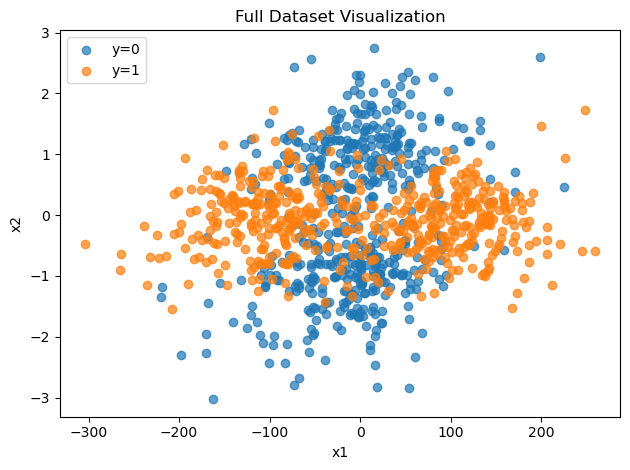

In [3]:
visualize(X, y, title="Full Dataset Visualization")

**(1) Feature Engineering: 2 Points**

Since logistic regression is a linear classifier, one can not expect to perform very well on data that is not linearly seperable. 

Try to figure out how to transform the data, e.g preprocessing original features and adding new features, such that the data becomes linearly seperable.

In [4]:
# Logistic Regression is a linear model, so polynomial features are added to map the data into a higher-dimensional space where the classes become
# linearly separable.

def create_features(X):
    """
    X shape: (N, 2) containing [x1, x2]
    Returns expanded feature matrix (N, 7)
    """
    x1 = X[:, 0]
    x2 = X[:, 1]

    # polynomial features from scratch 
    f1 = x1
    f2 = x2
    f3 = x1**2
    f4 = x2**2
    f5 = x1 * x2
    f6 = np.sqrt(np.abs(x1))
    f7 = np.sqrt(np.abs(x2))
    f8  = x1**3
    f9  = x2**3
    f10 = np.cos(x1) 
    f11 = np.cos(x2)

    # stack into a feature matrix
    X_new = np.column_stack([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11])
    return X_new


# create engineered features for train, val, test
x_train_fe = create_features(x_train)
x_val_fe   = create_features(x_val)
x_test_fe  = create_features(x_test)

# fit normalization on train only
mean = x_train_fe.mean(axis=0)
std  = x_train_fe.std(axis=0) + 1e-8


x_train_fe = (x_train_fe - mean) / std
x_val_fe   = (x_val_fe - mean) / std
x_test_fe  = (x_test_fe - mean) / std



print("Original train shape:", x_train.shape)
print("New train shape:", x_train_fe.shape)
print("New feature example (first 3 rows):")
print(x_train_fe[:3])

Original train shape: (700, 2)
New train shape: (700, 11)
New feature example (first 3 rows):
[[ 0.12864608  0.3289773  -0.78164467 -0.67326137  0.01296009 -1.39271893
  -0.75499877  0.0164869   0.02367958 -1.45104217  0.76279392]
 [ 0.21235831 -0.91497091 -0.76176911 -0.10959814 -0.27250878 -1.08572566
   0.38444397  0.01834511 -0.21113667 -0.65115338  0.03868185]
 [ 0.02234609  0.49268221 -0.7909146  -0.57462764 -0.03236594 -2.19282718
  -0.38118574  0.01608056  0.04663716  1.36483042  0.63118613]]


**(2) Training Logic: 2 Points**

Implement the training logic by finding the best model parameters for logistic regression. Since we have only 2 classes, BCE Loss is a proper loss function. 

Consider implementing regularization to avoid overfitting.

The training loop should take the training set (- and validation set for hyperparameter tuning later), aswell as the hyperparameters, initialize weights and do gradient descent. 

You should track the losses and accuracies throughout the epochs for later visualization.

In [5]:
def sigmoid(z):
    
    # compute the sigmoid function
    return 1 / (1 + np.exp(-z))

def predict(X, W, b):
    
    # predict probabilities for input X and returns values in (0,1)
    return sigmoid(X @ W + b)

def bce_loss(W, b, X, y, lam=0.0):
    
    # binary Cross Entropy loss with L2 regularization; y is {0,1}, predictions in (0,1)
    eps = 1e-8 
    p = predict(X, W, b)
    N = len(y) # number of training samples

    # BCE
    loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

    # L2 regularization
    loss += (lam / (2 * N)) * np.sum(W ** 2)

    return loss

def grad_bce_with_l2(W, b, X, y, lam=0.0):
    
    # compute gradients for BCE + L2 regularization and return dW, db
    p = predict(X, W, b)
    N = len(y)

    # gradients
    dW = (X.T @ (p - y)) / N + (lam / N) * W
    db = np.mean(p - y)

    return dW, db


def accuracy(y, p):
    
    # compute binary classification accuracy; p are probabilities, threshold at 0.5
    preds = (p >= 0.5).astype(int)
    return np.mean(preds == y)


def train_model(X_tr, y_tr, X_val, y_val, lr=0.1, lam=0.0, epochs=100, verbose=True):

    # train logistic regression using gradient descent and track losses + accuracy over epochs
    N, D = X_tr.shape

    # initialize parameters
    W = np.zeros(D)
    b = 0.0

    # tracking
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):

        # compute gradients
        dW, db = grad_bce_with_l2(W, b, X_tr, y_tr, lam)

        # update parameters
        W -= lr * dW
        b -= lr * db

        # track metrics
        p_tr = predict(X_tr, W, b)
        p_val = predict(X_val, W, b)

        train_losses.append(bce_loss(W, b, X_tr, y_tr, lam))
        val_losses.append(bce_loss(W, b, X_val, y_val, lam))

        train_accs.append(accuracy(y_tr, p_tr))
        val_accs.append(accuracy(y_val, p_val))

        # print progress
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch}: loss={train_losses[-1]:.4f}, acc={train_accs[-1]:.3f}")

    return W, b, train_losses, val_losses, train_accs, val_accs

**(3) Hyperparameter tuning: 0.5 Points**

Your logistic regression model has hyperparameters, e.g. learning rate/regularization lambda, and since there are no  best hyperparameters in general, one has to find them by grid searching through them for the specific model.

Implement the grid search function by going through all possible defined parameters, train the model and evaluate on validation set. 

Save the best hyperparameters and return them.

In [6]:
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05] 
lambda_list = [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0]
def grid_search(X_tr, y_tr, X_val, y_val, lr_list, lambda_list,  epochs=200):
    best_lr = None
    best_lambda = None
    best_val_acc = -1  # track the highest validation accuracy

    for lr in lr_list:
        for lam in lambda_list:

            # train the model with given hyperparameters
            W, b, train_losses, val_losses, train_accs, val_accs = train_model(
                X_tr, y_tr, X_val, y_val,
                lr=lr, lam=lam, epochs=epochs, verbose=False
            )

            # validation accuracy at last epoch
            val_acc = val_accs[-1]

            # check if this is the best so far
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_lr = lr
                best_lambda = lam

    print(f"Best validation accuracy found: {best_val_acc:.4f}")
    
    return best_lr, best_lambda

**(4) Training and (5) Testing: 0.5 Points**

- Use grid search to find the best hyperparameters
- train your model with found hyperparameters
- visualize loss and accuracy curves
- test your model on the testing set

In [7]:
# grid search to find the best hyperparameters

best_lr, best_lambda = grid_search(x_train_fe, y_train, x_val_fe, y_val, lr_list, lambda_list, epochs=500)

print(f"Best hyperparameters: lr={best_lr}, lam={best_lambda}")

Best validation accuracy found: 0.8133
Best hyperparameters: lr=0.0001, lam=0.0001


In [8]:
# train your model with found hyperparameters
W_best, b_best, train_losses, val_losses, train_accs, val_accs = train_model(
    x_train_fe, y_train,
    x_val_fe, y_val,
    lr=best_lr,
    lam=best_lambda,
    epochs=500
)

Epoch 0: loss=0.6931, acc=0.849
Epoch 10: loss=0.6927, acc=0.849
Epoch 20: loss=0.6923, acc=0.849
Epoch 30: loss=0.6919, acc=0.849
Epoch 40: loss=0.6915, acc=0.849
Epoch 50: loss=0.6911, acc=0.849
Epoch 60: loss=0.6908, acc=0.849
Epoch 70: loss=0.6904, acc=0.849
Epoch 80: loss=0.6900, acc=0.849
Epoch 90: loss=0.6896, acc=0.849
Epoch 100: loss=0.6892, acc=0.849
Epoch 110: loss=0.6888, acc=0.849
Epoch 120: loss=0.6884, acc=0.849
Epoch 130: loss=0.6880, acc=0.849
Epoch 140: loss=0.6877, acc=0.849
Epoch 150: loss=0.6873, acc=0.849
Epoch 160: loss=0.6869, acc=0.849
Epoch 170: loss=0.6865, acc=0.849
Epoch 180: loss=0.6861, acc=0.850
Epoch 190: loss=0.6857, acc=0.850
Epoch 200: loss=0.6854, acc=0.850
Epoch 210: loss=0.6850, acc=0.850
Epoch 220: loss=0.6846, acc=0.850
Epoch 230: loss=0.6842, acc=0.850
Epoch 240: loss=0.6838, acc=0.850
Epoch 250: loss=0.6835, acc=0.850
Epoch 260: loss=0.6831, acc=0.850
Epoch 270: loss=0.6827, acc=0.850
Epoch 280: loss=0.6823, acc=0.850
Epoch 290: loss=0.6819, a

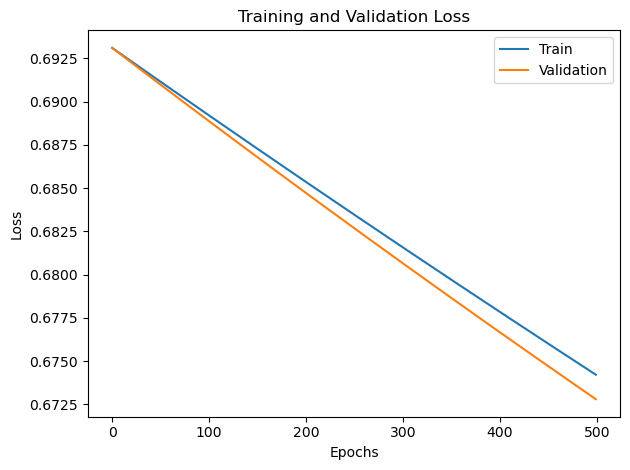

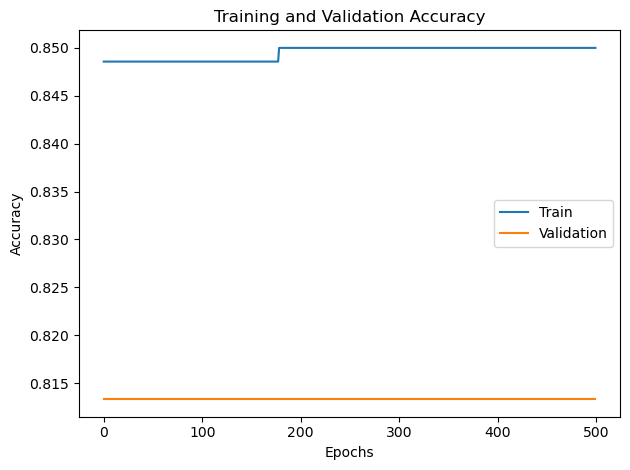

In [9]:
# visualize loss and accuracy curves
def plot_curves(train_values, val_values, ylabel, title):
    plt.figure()
    plt.plot(train_values, label="Train")
    plt.plot(val_values, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_curves(train_losses, val_losses, ylabel="Loss", title="Training and Validation Loss")
plot_curves(train_accs, val_accs, ylabel="Accuracy", title="Training and Validation Accuracy")

In [10]:
# Test the model
p_test = predict(x_test_fe, W_best, b_best)
test_acc = accuracy(y_test, p_test)

print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.7800
